### Loan Default Prediction: Model Building & Evaluation




####  Predictive Modeling

**Objective:** Build and evaluate machine learning models to predict loan defaults.

**Models to test:**
1. Logistic Regression (baseline)
2. Random Forest
3. XGBoost (if time)
4. Compare performance

**Key considerations:**
- Class imbalance (~17% default rate)
- Feature importance analysis
- Business-focused metrics (cost of false positives vs false negatives)



In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Load encoded data
df = pd.read_csv('../data/processed/encoded_loan_data.csv')
print(f"Dataset shape: {df.shape}")
print(f"Features: {df.shape[1] - 1}")
print(f"Target variable: default")

Dataset shape: (15000, 33)
Features: 32
Target variable: default


In [21]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

##### Train test split

In [22]:
# Separate features and target
X = df.drop('default', axis=1)
y = df['default']

print("Features (X):")
print(f"  Shape: {X.shape}")
print(f"  Columns: {X.columns.tolist()}")

print("\nTarget (y):")
print(f"  Shape: {y.shape}")
print(f"  Distribution:\n{y.value_counts()}")

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintains class distribution
)

print("\n" + "="*60)
print("TRAIN-TEST SPLIT COMPLETE")
print("="*60)
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df):.0%})")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(df):.0%})")

print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"Default rate: {y_train.mean():.2%}")

print(f"\nClass distribution in test set:")
print(y_test.value_counts())
print(f"Default rate: {y_test.mean():.2%}")

# Verify stratification worked
assert abs(y_train.mean() - y_test.mean()) < 0.01, "Stratification failed!"
print("\n Stratification successful - class balance maintained!")

Features (X):
  Shape: (15000, 32)
  Columns: ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_low', 'revol_util', 'loan_to_income', 'grade_encoded', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'home_ownership_OWN', 'home_ownership_RENT', 'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years', 'emp_length_< 1 year', 'emp_length_Unknown']

Target (y):
  Shape: (15000,)
  Distribution:
default
0    12391
1     2609
Name: count, dtype: int64

TRAIN-TEST SPLIT COMPLETE
Training set: 12000 samples (80%)
Test set: 3000 samples (20%)

Class distribution in training set:
default
0    9913
1    2087
Name: count, dtype: int64
Default rate: 

##### Feature Scaling

In [23]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


print(f"Original mean: {X_train['loan_amnt'].mean():.2f}")
print(f"Scaled mean: {X_train_scaled['loan_amnt'].mean():.2f}")
print(f"Scaled std: {X_train_scaled['loan_amnt'].std():.2f}")

Original mean: 15079.31
Scaled mean: 0.00
Scaled std: 1.00


##### Handling Class Imbalance with SMOTE

In [24]:
# Apply SMOTE to training data only
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("Class Distribution:")
print("="*60)
print("\nBefore SMOTE (Original):")
print(y_train.value_counts())
print(f"Imbalance ratio: {(y_train==0).sum() / (y_train==1).sum():.1f}:1")

print("\nAfter SMOTE (Balanced):")
print(y_train_balanced.value_counts())
print(f"Imbalance ratio: {(y_train_balanced==0).sum() / (y_train_balanced==1).sum():.1f}:1")

print(f"\n Training set balanced!")
print(f"   Original size: {len(y_train)}")
print(f"   Balanced size: {len(y_train_balanced)}")

Class Distribution:

Before SMOTE (Original):
default
0    9913
1    2087
Name: count, dtype: int64
Imbalance ratio: 4.7:1

After SMOTE (Balanced):
default
0    9913
1    9913
Name: count, dtype: int64
Imbalance ratio: 1.0:1

 Training set balanced!
   Original size: 12000
   Balanced size: 19826


###### Model Building & Training

We'll train three models and compare their performance:
1. **Logistic Regression** - Simple, interpretable baseline
2. **Random Forest** - Ensemble method, handles non-linearity
3. **XGBoost** - Gradient boosting, often best performance

In [25]:
# Train on balanced data
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_balanced, y_train_balanced)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print(" Logistic Regression trained!")

 Logistic Regression trained!


In [26]:

# Train on balanced data
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)
rf_model.fit(X_train_balanced, y_train_balanced)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print(" Random Forest trained!")

 Random Forest trained!


In [27]:
from xgboost import XGBClassifier
# Train on balanced data
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train_balanced, y_train_balanced)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

print(" XGBoost trained!")

ValueError: feature_names must be string, and may not contain [, ] or <

In [ ]:
# Clean column names for XGBoost
def clean_column_names(df):
    """Remove special characters from column names"""
    df.columns = df.columns.str.replace('[', '', regex=False)
    df.columns = df.columns.str.replace(']', '', regex=False)
    df.columns = df.columns.str.replace('<', '', regex=False)
    df.columns = df.columns.str.replace('>', '', regex=False)
    return df

# Apply to all datasets
X_train_balanced = clean_column_names(X_train_balanced)
X_test_scaled = clean_column_names(X_test_scaled)

print(" Column names cleaned for XGBoost")
print(f"Sample columns: {X_train_balanced.columns[:5].tolist()}")

 Column names cleaned for XGBoost
Sample columns: ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_low']


In [ ]:


# Train on balanced data
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    enable_categorical=False
)
xgb_model.fit(X_train_balanced, y_train_balanced)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

print(" XGBoost trained!")

 XGBoost trained!


##### Model Evaluation & Comparison

We'll evaluate models using multiple metrics:
- **Accuracy**: Overall correctness
- **Precision**: Of predicted defaults, how many were actual defaults?
- **Recall**: Of actual defaults, how many did we catch?
- **F1-Score**: Harmonic mean of precision and recall
- **ROC-AUC**: Overall discriminative ability

In [ ]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """Calculate and display all metrics for a model"""


    print(f"{model_name.upper()} - PERFORMANCE METRICS")


    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    # Display
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    # Classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Non-Default', 'Default']))

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

# Evaluate all models
results = []

results.append(evaluate_model(y_test, y_pred_lr, y_pred_proba_lr, "Logistic Regression"))
results.append(evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, "Random Forest"))
results.append(evaluate_model(y_test, y_pred_xgb, y_pred_proba_xgb, "XGBoost"))

# Create comparison DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(results_df.to_string(index=False))

LOGISTIC REGRESSION - PERFORMANCE METRICS
Accuracy:  0.6307
Precision: 0.2637
Recall:    0.6264
F1-Score:  0.3712
ROC-AUC:   0.6700

Detailed Classification Report:
              precision    recall  f1-score   support

 Non-Default       0.89      0.63      0.74      2478
     Default       0.26      0.63      0.37       522

    accuracy                           0.63      3000
   macro avg       0.58      0.63      0.55      3000
weighted avg       0.78      0.63      0.67      3000

RANDOM FOREST - PERFORMANCE METRICS
Accuracy:  0.6777
Precision: 0.2699
Recall:    0.5000
F1-Score:  0.3506
ROC-AUC:   0.6597

Detailed Classification Report:
              precision    recall  f1-score   support

 Non-Default       0.87      0.72      0.79      2478
     Default       0.27      0.50      0.35       522

    accuracy                           0.68      3000
   macro avg       0.57      0.61      0.57      3000
weighted avg       0.77      0.68      0.71      3000

XGBOOST - PERFORMANCE 

Logistic Regression is best for detecting defaults (high recall), Random Forest is balanced but weaker, and XGBoost achieves high accuracy by ignoring most defaults — making it the worst for loan default prediction.

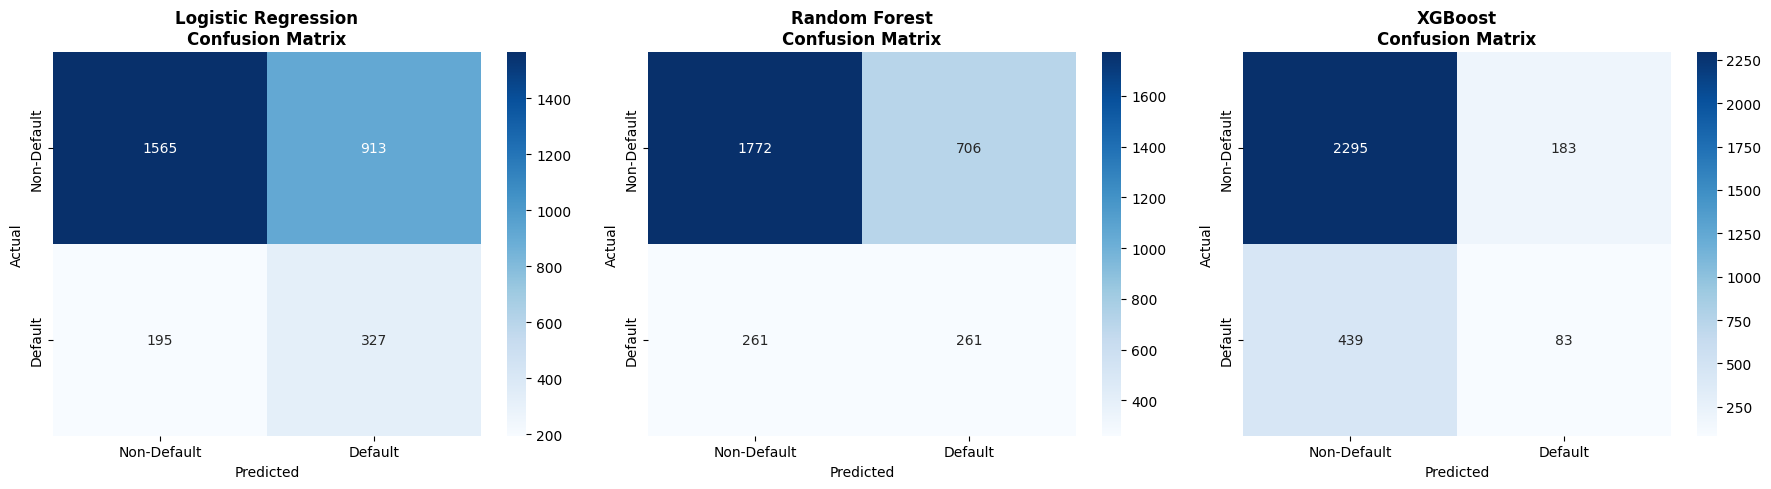

In [ ]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
    ('Logistic Regression', y_pred_lr),
    ('Random Forest', y_pred_rf),
    ('XGBoost', y_pred_xgb)
]

for idx, (name, y_pred) in enumerate(models):
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Non-Default', 'Default'],
                yticklabels=['Non-Default', 'Default'])

    axes[idx].set_title(f'{name}\nConfusion Matrix', fontweight='bold')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

| Model                   | What It Does Well                   | What It Does Badly                    | Use Case                     |
| ----------------------- | ----------------------------------- | ------------------------------------- | ---------------------------- |
| **Logistic Regression** | Finds many defaulters (best recall) | Flags too many good clients           | Risk-averse lenders          |
| **Random Forest**       | Balanced predictions                | Misses more defaults                  | Moderate risk tolerance      |
| **XGBoost**             | High accuracy                       | Fails on the minority class (default) |  Not acceptable for finance |


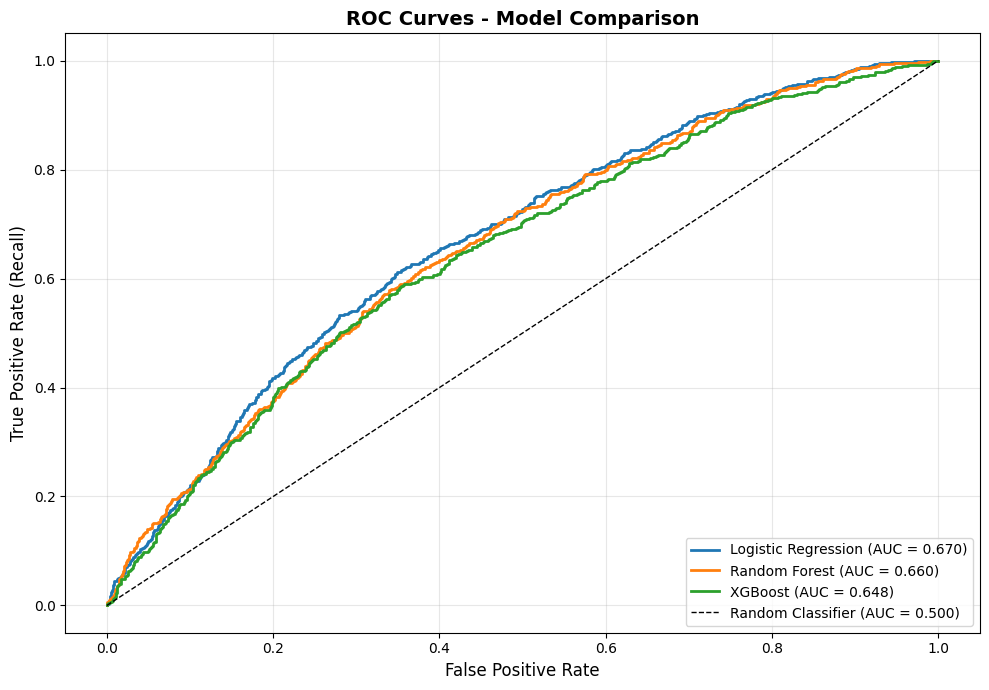

In [28]:
# Plot ROC curves
plt.figure(figsize=(10, 7))

models_proba = [
    ('Logistic Regression', y_pred_proba_lr),
    ('Random Forest', y_pred_proba_rf),
    ('XGBoost', y_pred_proba_xgb)
]

for name, y_proba in models_proba:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

# Diagonal reference line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import pickle


with open('../models/logistic_regression.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("Logistic Regression saved")

with open('../models/random_forest.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("Random Forest saved")

with open('../models/xgboost.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
print("XGBoost saved")

# Save the scaler
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(" Scaler saved")

# Save feature names
feature_names = X_train.columns.tolist()
with open('../models/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
print(" Feature names saved")

print("\n All models saved successfully!")

Logistic Regression saved
Random Forest saved
XGBoost saved
 Scaler saved
 Feature names saved

 All models saved successfully!
